In [1]:
import networkx as nx
import numpy as np
import pcabm.sc as sc
import pcabm.pcabm as pca
from sklearn.metrics.cluster import adjusted_rand_score

# Data Preprocessing

In [2]:
# Read data
G = nx.read_gml('Data/polblogs.gml')
A = nx.adjacency_matrix(G)
A = A.todense()
Ab=((A+A.T)!=0).astype(int)
np.fill_diagonal(Ab,0)

In [3]:
# Find the largest cluster 
start=0
check_set=set(np.nonzero(Ab[start,:])[1])
comm_set=set()
while len(check_set)>0:
    bar = check_set.copy()
    for item in bar:
        temp=set(np.nonzero(Ab[item,:])[1])-comm_set
        check_set=check_set|temp
        check_set.discard(item)
        comm_set=comm_set|{item}
comm_set=np.array(list(comm_set))
Ab = np.array(Ab[np.ix_(comm_set,comm_set)])

In [4]:
# Create Label
label=[]
for index in comm_set:
    label.append(G.node[list(G.node.keys())[index]]['value'])
label = np.array(label)

# Create Covariate
k,p,n=2,1,1222
degree = sum(Ab)
Z = np.zeros(n*n*p);Z=Z.reshape((n,n,p))
for i in np.arange(0,n):
    for j in np.arange(0,n):
        Z[i,j,0] = np.log(degree[i]*degree[j])

# Spectral Clustering

In [22]:
modelSC = sc.SC(Ab,2)
print('ARI is',adjusted_rand_score(modelSC.labels_,label))

ARI is 0.07990011061571035


# PCABM

In [23]:
modelPCA = pca.PCABM(Ab,Z,2,gamma_est)
estPCA,_ = modelPCA.fit(gt=label,init = 30, tabu_size=300,max_iterations=5000,max_stay=300)
print('ARI is',adjusted_rand_score(estPCA,label))

ARI is 0.7838148145129697


(array([ 67905., 116296., 215206., 308906., 302313., 251239., 161233.,
         61119.,   8714.,    353.]),
 array([ 0.        ,  1.17215724,  2.34431449,  3.51647173,  4.68862898,
         5.86078622,  7.03294347,  8.20510071,  9.37725796, 10.5494152 ,
        11.72157245]),
 <a list of 10 Patch objects>)

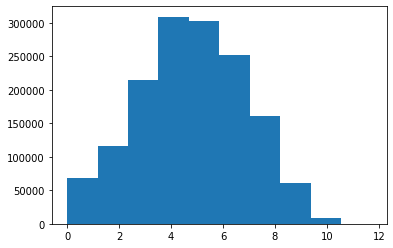

In [13]:
import matplotlib.pyplot as plt
plt.hist(Z.flatten())